In [86]:
import pandas as pd
from pathlib import Path
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

### Extract age, id information for ADNI

In [96]:
# Read age.csv
path = '/mnt/share/raheppt1/project_data/brain/ADNI/config/PTDEMOG.csv'
df = pd.read_csv(path)
df =df[['RID', 'PTDOBYY']]
print(df[df['RID']==685].mean()['PTDOBYY'])
print(df.columns)

1916.0
Index(['RID', 'PTDOBYY'], dtype='object')


In [97]:
# Read diagnosis.csv
path = '/mnt/share/raheppt1/project_data/brain/ADNI/config/DXSUM_PDXCONV_ADNIALL.csv'
df_diag = pd.read_csv(path)
df_diag =df_diag[['RID', 'DXCURREN']]
print(df_diag[df_diag['RID']==295]['DXCURREN'].max())

1.0


In [98]:
work_dir = Path('/mnt/share/raheppt1/project_data/brain/ADNI/ADNI_T1/')

files = work_dir.glob('**/fcmnorm*brain*.nii*')

In [99]:
results = {'id': [], 'age': [], 'diag': []}
for file in files:
    print(file)
    m = re.match('.*ADNI_(.*)_T1.nii*', file.name)
    subj_id = m.group(1)
    m = re.match('.*ADNI_.*_S_[0-9]{4}_([0-9]{4}).*_T1.*', file.name)
    date = float(m.group(1))
    m = re.match('.*ADNI_.*_S_([0-9]{4}).*_T1.*', file.name)
    rid = int(m.group(1))
    dob = df[df['RID']==rid].mean()['PTDOBYY']
    diag_min = df_diag[df_diag['RID']==rid]['DXCURREN'].min()
    age = date - dob
    #print(dob)
    #print(age)
    #print(diag)
    #print(file)
    #print(date)
    #print(subj_id)
    #print(rid)
    results['id'].append(subj_id)
    results['age'].append(age)
    results['diag'].append(diag_min)
df_res = pd.DataFrame.from_dict(results)
print(results)

/mnt/share/raheppt1/project_data/brain/ADNI/ADNI_T1/fcmnorm_brain_mni_ADNI_002_S_0295_20070219173850420_T1.nii.gz
/mnt/share/raheppt1/project_data/brain/ADNI/ADNI_T1/fcmnorm_brain_mni_ADNI_002_S_0413_20081001120813046_T1.nii.gz
/mnt/share/raheppt1/project_data/brain/ADNI/ADNI_T1/fcmnorm_brain_mni_ADNI_002_S_0413_20081015122825655_T1.nii.gz
/mnt/share/raheppt1/project_data/brain/ADNI/ADNI_T1/fcmnorm_brain_mni_ADNI_002_S_0295_20070802163833409_T1.nii.gz
/mnt/share/raheppt1/project_data/brain/ADNI/ADNI_T1/fcmnorm_brain_mni_ADNI_002_S_0295_20081001114556321_T1.nii.gz
/mnt/share/raheppt1/project_data/brain/ADNI/ADNI_T1/fcmnorm_brain_mni_ADNI_002_S_0295_20081001120532722_T1.nii.gz
/mnt/share/raheppt1/project_data/brain/ADNI/ADNI_T1/fcmnorm_brain_mni_ADNI_002_S_0413_20081001114742166_T1.nii.gz
/mnt/share/raheppt1/project_data/brain/ADNI/ADNI_T1/fcmnorm_brain_mni_ADNI_002_S_0619_20081001115218896_T1.nii.gz
/mnt/share/raheppt1/project_data/brain/ADNI/ADNI_T1/fcmnorm_brain_mni_ADNI_002_S_0413_20

804
935
440


,id,age,diag
0,002_S_0295_20070219173850420,86.0,1.0
1,002_S_0413_20081001120813046,79.0,1.0
2,002_S_0413_20081015122825655,79.0,1.0
3,002_S_0295_20070802163833409,86.0,1.0
4,002_S_0295_20081001114556321,87.0,1.0
...,...,...,...
2174,941_S_1202_20101111125148227,81.0,1.0
2175,941_S_1194_20101111124352386,88.0,1.0
2176,941_S_1202_20090227162901056,80.0,1.0
2177,941_S_1202_20080514112323070,79.0,1.0


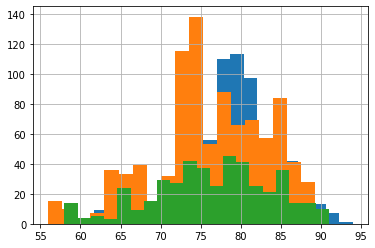

In [100]:
hist = df_res.loc[df_res['diag']==1.0]['age'].hist(bins=20)
hist = df_res.loc[df_res['diag']==2.0]['age'].hist(bins=20)
hist = df_res.loc[df_res['diag']==3.0]['age'].hist(bins=20)
print(df_res.loc[df_res['diag']==1.0]['age'].count())
print(df_res.loc[df_res['diag']==2.0]['age'].count())
print(df_res.loc[df_res['diag']==3.0]['age'].count())
df_res

In [101]:
df_res.to_csv(str(work_dir.parent.joinpath('config', 'ADNI_age.csv')), index=False, header=False)

In [102]:
df_res[['id','age']].to_csv(str(work_dir.parent.joinpath('config', 'ADNI_age_only.csv')), index=False, header=False)


### Cross-validation

id      100
age     100
diag    100
dtype: int64
id      704
age     704
diag    704
dtype: int64


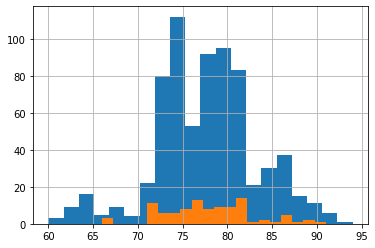

In [123]:
work_dir = Path('/mnt/share/raheppt1/project_data/brain/ADNI/config')
df = pd.read_csv(str(work_dir.joinpath('ADNI_age.csv')), 
                 names=['id', 'age', 'diag'],
                 dtype={'id': str, 'age': float, 'diag': float})

out_dir = work_dir.joinpath('GR_NL')
df_sel = df.loc[df['diag']==1.0]
praefix = 'NL_'
test_split = 100
n_splits = 10

# Select <test_split> random samples for testing.
df_test = df_sel.sample(n=test_split, frac=None, replace=False, weights=None, random_state=None, axis=None)

df_trainval = df_sel.drop(df_test.index)
print(df_test.count())
print(df_trainval.count())

hist = df_trainval['age'].hist(bins=20)
hist = df_test['age'].hist(bins=20)

/mnt/share/raheppt1/project_data/brain/ADNI/config/GR_NL/NL_ADNI_T1_train_split0.csv
/mnt/share/raheppt1/project_data/brain/ADNI/config/GR_NL/NL_ADNI_T1_val_split0.csv
/mnt/share/raheppt1/project_data/brain/ADNI/config/GR_NL/NL_ADNI_T1_train_split1.csv
/mnt/share/raheppt1/project_data/brain/ADNI/config/GR_NL/NL_ADNI_T1_val_split1.csv
/mnt/share/raheppt1/project_data/brain/ADNI/config/GR_NL/NL_ADNI_T1_train_split2.csv
/mnt/share/raheppt1/project_data/brain/ADNI/config/GR_NL/NL_ADNI_T1_val_split2.csv
/mnt/share/raheppt1/project_data/brain/ADNI/config/GR_NL/NL_ADNI_T1_train_split3.csv
/mnt/share/raheppt1/project_data/brain/ADNI/config/GR_NL/NL_ADNI_T1_val_split3.csv
/mnt/share/raheppt1/project_data/brain/ADNI/config/GR_NL/NL_ADNI_T1_train_split4.csv
/mnt/share/raheppt1/project_data/brain/ADNI/config/GR_NL/NL_ADNI_T1_val_split4.csv
/mnt/share/raheppt1/project_data/brain/ADNI/config/GR_NL/NL_ADNI_T1_train_split5.csv
/mnt/share/raheppt1/project_data/brain/ADNI/config/GR_NL/NL_ADNI_T1_val_spl

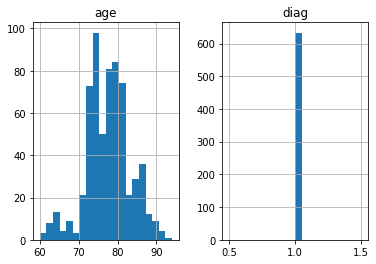

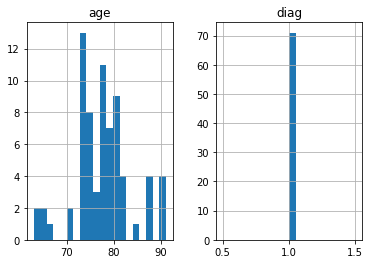

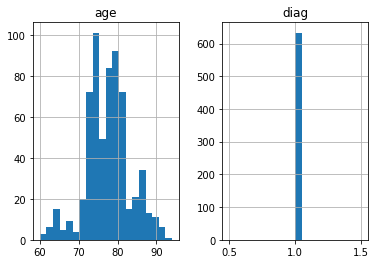

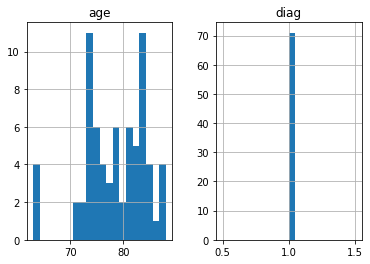

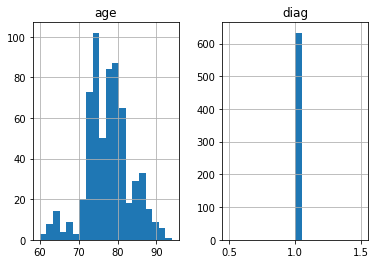

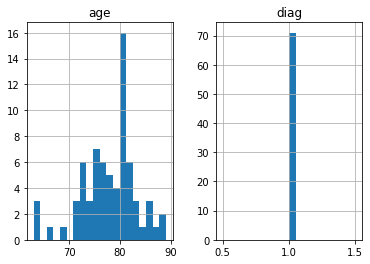

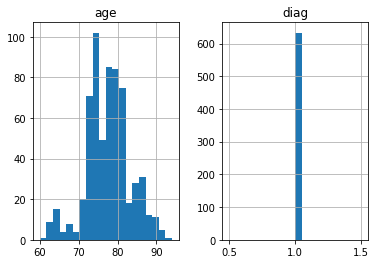

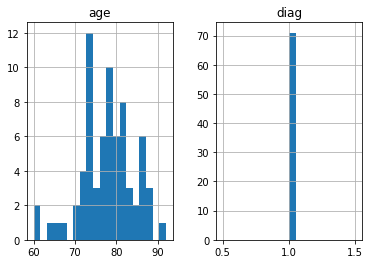

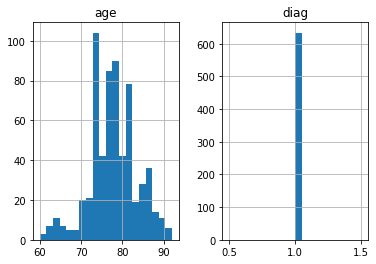

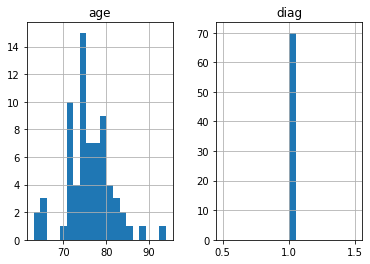

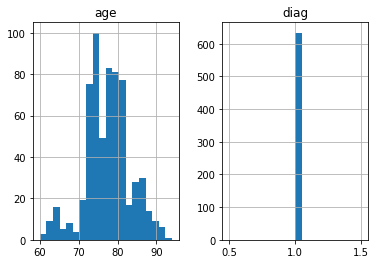

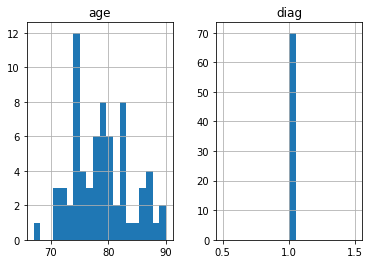

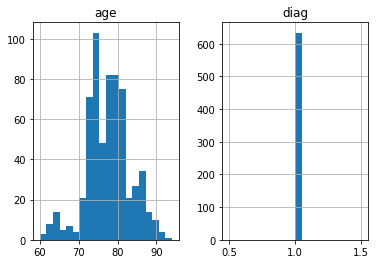

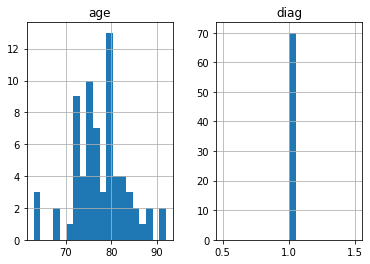

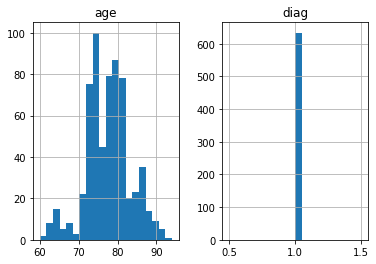

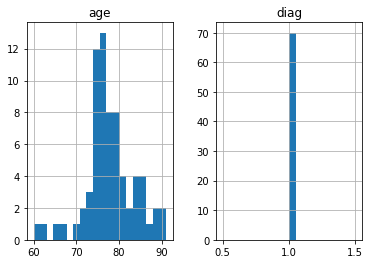

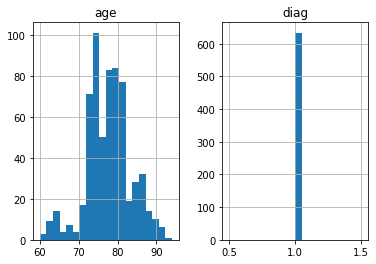

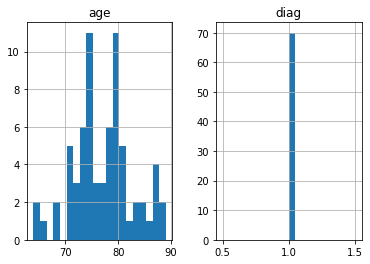

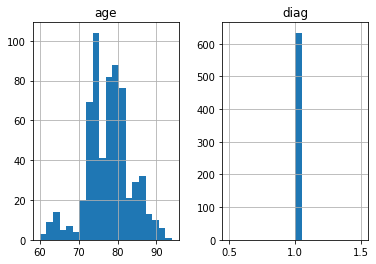

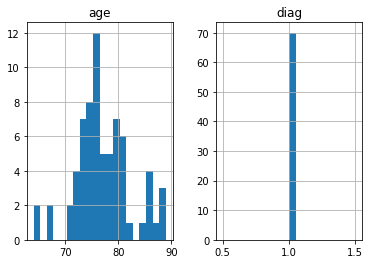

In [124]:
X = df_trainval.values.tolist()
kf = KFold(n_splits=n_splits, shuffle=True)
kf.get_n_splits(X)

split = 0
for train_index, test_index in kf.split(X):
    out_path = out_dir.joinpath(f'{praefix}ADNI_T1_train_split{split}.csv')
    print(out_path)
    df_trainval.iloc[train_index].to_csv(str(out_path), index=False, header=False)
    out_path = out_dir.joinpath(f'{praefix}ADNI_T1_val_split{split}.csv')
    print(out_path)
    df_trainval.iloc[test_index].to_csv(str(out_path), index=False, header=False)
    split = split + 1
    hist = df_trainval.iloc[train_index].hist(bins=20)
    hist = df_trainval.iloc[test_index].hist(bins=20)
out_path = out_dir.joinpath(f'{praefix}ADNI_T1_test_split.csv')
print(out_path)
df_test.to_csv(str(out_path), index=False, header=False)

df_test = df_sel.iloc[:, 0]
out_path = out_dir.joinpath(f'{praefix}ADNI_T1_test_complete.csv')
print(out_path)
df_test.to_csv(str(out_path), index=False, header=False)

# IXI cross validation

In [16]:
work_dir = Path('/mnt/share/raheppt1/project_data/brain/IXI/IXI_T1/config')
df = pd.read_csv(str(work_dir.joinpath('IXI_T1_age.csv')), 
                 names=['id', 'age'],
                 dtype={'id': str, 'age': float})

In [81]:
# Select 100 random samples for testing.
df_test = df.sample(n=100, frac=None, replace=False, weights=None, random_state=None, axis=None)
df_trainval = df.drop(df_test.index)

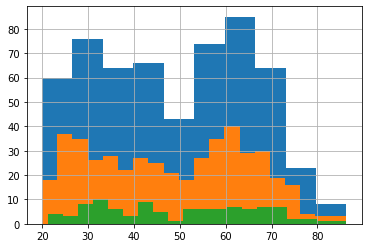

In [92]:
# Plot age histograms.
hist = df['age'].hist(bins=10)
hist = df_trainval['age'].hist(bins=20)
hist = df_test['age'].hist(bins=20)

In [93]:
# Create cross-validation
test_split = 100
n_splits = 10
X = df_trainval.values.tolist()
kf = KFold(n_splits=n_splits, shuffle=True)
kf.get_n_splits(X)

10

In [94]:
split = 0
for train_index, val_index in kf.split(X):
    out_path = work_dir.joinpath(f'IXI_T1_train_split{split}.csv')
    print(out_path)
    df_trainval.iloc[train_index].to_csv(str(out_path), index=False, header=False)
    out_path = work_dir.joinpath(f'IXI_T1_val_split{split}.csv')
    print(out_path)
    df_trainval.iloc[val_index].to_csv(str(out_path), index=False, header=False)
    split = split + 1
    #hist = df_trainval.iloc[train_index].hist(bins=10)
    #hist = df_trainval.iloc[val_index].hist(bins=10)

/mnt/share/raheppt1/project_data/brain/IXI/IXI_T1/config/IXI_T1_train_split0.csv
/mnt/share/raheppt1/project_data/brain/IXI/IXI_T1/config/IXI_T1_val_split0.csv
/mnt/share/raheppt1/project_data/brain/IXI/IXI_T1/config/IXI_T1_train_split1.csv
/mnt/share/raheppt1/project_data/brain/IXI/IXI_T1/config/IXI_T1_val_split1.csv
/mnt/share/raheppt1/project_data/brain/IXI/IXI_T1/config/IXI_T1_train_split2.csv
/mnt/share/raheppt1/project_data/brain/IXI/IXI_T1/config/IXI_T1_val_split2.csv
/mnt/share/raheppt1/project_data/brain/IXI/IXI_T1/config/IXI_T1_train_split3.csv
/mnt/share/raheppt1/project_data/brain/IXI/IXI_T1/config/IXI_T1_val_split3.csv
/mnt/share/raheppt1/project_data/brain/IXI/IXI_T1/config/IXI_T1_train_split4.csv
/mnt/share/raheppt1/project_data/brain/IXI/IXI_T1/config/IXI_T1_val_split4.csv
/mnt/share/raheppt1/project_data/brain/IXI/IXI_T1/config/IXI_T1_train_split5.csv
/mnt/share/raheppt1/project_data/brain/IXI/IXI_T1/config/IXI_T1_val_split5.csv
/mnt/share/raheppt1/project_data/brain/I

In [95]:
out_path = work_dir.joinpath(f'IXI_T1_test.csv')
df_test.to_csv(str(out_path), index=False, header=False)

### IXI id (zfill)

In [134]:
csv_path = '/mnt/share/raheppt1/project_data/brain/IXI/IXI_T1/config/IXI_T1_age.csv'
df = pd.read_csv(csv_path, names=['id', 'age'])

In [138]:
df['id'] = df['id'].astype(str)
df['id'] = df['id'].str.zfill(3)

In [140]:
df.to_csv(csv_path, header=False, index=False)